Tak, w Jupyter Notebooku możesz używać poleceń shellowych (takich jak conda create czy pip install) bezpośrednio z poziomu komórek. Wystarczy poprzedzić komendę znakiem wykrzyknika !.

Utworzenie nowego środowiska<br>
!conda create -n mushroom-env python=3.9 -y

Aktywacja środowiska (niestety nie zadziała w Jupyterze – patrz uwaga niżej)<br>
!conda activate mushroom-env

Instalacja bibliotek w bieżącym środowisku Jupyter<br>
!pip install torch torchvision timm matplotlib

Aktywacja środowiska w Jupyterze:<br>

Jupyter uruchamia się w środowisku, w którym został zainstalowany. Nie możesz aktywować innego środowiska w bieżącym notebooku za pomocą conda activate.
Aby użyć nowego środowiska (mushroom-env) w Jupyterze, musisz dodać to środowisko jako kernel do Jupytera.
Dodanie środowiska jako kernel w Jupyterze: Po utworzeniu środowiska, uruchom następujące komendy w terminalu (nie w Jupyterze):<br>

bash<br>
Copy code<br>
conda activate mushroom-env<br>
pip install ipykernel<br>
python -m ipykernel install --user --name=mushroom-env --display-name "Python (mushroom-env)"<br>
Dzięki temu w Jupyterze będziesz mógł wybrać kernel o nazwie Python (mushroom-env).<br>

Korzystanie z nowego środowiska:<br>

Po dodaniu środowiska jako kernel, otwórz Jupyter Notebook.<br>
Kliknij w menu: Kernel → Change Kernel → Python (mushroom-env).<br>
Od teraz notebook będzie działał w nowym środowisku.<br>


In [14]:
from torchvision import datasets
from torchvision import transforms
import torch
import os


script_directory = os.getcwd()

directory_path_train = os.path.join(script_directory, "scripts","downloaded_images","train")
directory_path_val = os.path.join(script_directory, "scripts","downloaded_images", "val")
directory_path_pre_trained = os.path.join(script_directory, "scripts","DF20-EfficientNet-B0-224_best_accuracy.pth")


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # Normalize means subtract mean, divide by std for each color channel
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(directory_path_train, transform=train_transforms)
val_dataset   = datasets.ImageFolder(directory_path_val,   transform=val_transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False, num_workers=0
)

In [15]:
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.optim as optim

# Model setup
model_name = "resnet50"
model = timm.create_model(model_name, pretrained=True)
num_classes = 17
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training configuration
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0

    # Add tqdm for the training loop
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    
    # Validation phase with tqdm
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    print(f"Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/5


Loss: 2.4947, Val Accuracy: 31.87%
Epoch 2/5


Loss: 1.9485, Val Accuracy: 53.66%
Epoch 3/5


Loss: 1.3923, Val Accuracy: 67.22%
Epoch 4/5


Loss: 0.9785, Val Accuracy: 75.82%
Epoch 5/5


Loss: 0.7496, Val Accuracy: 77.66%


In [1]:
import torch

print(torch.cuda.is_available())  # Powinno zwrócić True
print(torch.backends.cudnn.is_available())  # Powinno zwrócić True
print(torch.backends.cudnn.version())

True
True
90100


In [10]:
import os
from collections import Counter
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report
from tqdm import tqdm
import timm

# Ustawienia
script_directory = os.getcwd()
directory_path_train = os.path.join(script_directory, "scripts", "downloaded_images", "train")
directory_path_val = os.path.join(script_directory, "scripts", "downloaded_images", "val")
directory_path_pre_trained = os.path.join(script_directory, "scripts", "DF20-EfficientNet-B0-224_best_accuracy.pth")
#directory_path_pre_trained = os.path.join(script_directory, "scripts", "DF20-ViT_large_patch16_224_best_accuracy")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 17  # Liczba klas w Twoim zbiorze danych
num_epochs = 5
batch_size = 32
learning_rate = 1e-4

# Transformacje danych
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset i DataLoader
train_dataset = datasets.ImageFolder(directory_path_train, transform=train_transforms)
val_dataset = datasets.ImageFolder(directory_path_val, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Obliczanie wag klas
class_counts = Counter([label for _, label in train_dataset.samples])
class_weights = torch.FloatTensor([1.0 / class_counts[c] if class_counts[c] > 0 else 0 for c in range(len(train_dataset.classes))])
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Model
model_name = "efficientnet_b0"
model = timm.create_model(model_name, pretrained=False, num_classes=1604)
checkpoint = torch.load(directory_path_pre_trained, map_location=device)
model.load_state_dict(checkpoint, strict=False)

# Zamrożenie wcześniejszych warstw
for param in model.parameters():
    param.requires_grad = False

# Dostosowanie ostatniej warstwy
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

# Optymalizator i scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Pętla treningowa
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Training Loss: {avg_loss:.4f}")

    # Walidacja
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Raport klasyfikacji po ostatniej epoce
    if epoch == num_epochs - 1:
        print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    # Aktualizacja współczynnika uczenia
    scheduler.step()

print("Trening zakończony!")


C:\Users\filip\AppData\Local\Temp\ipykernel_4488\3030632140.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(directory_path_pre_trained, map_loca

Epoch 1/5


Training Loss: 2.8383


Validation Accuracy: 10.99%
Epoch 2/5


Training Loss: 2.8273


Validation Accuracy: 13.92%
Epoch 3/5


Training Loss: 2.8207


Validation Accuracy: 14.47%
Epoch 4/5


Training Loss: 2.8193


Validation Accuracy: 13.92%
Epoch 5/5


Training Loss: 2.8167


Validation Accuracy: 14.10%
                        precision    recall  f1-score   support

     Agaricus_bisporus       0.00      0.00      0.00         6
   Agaricus_campestris       0.33      0.01      0.03        71
      Amanita_muscaria       0.29      0.08      0.12        77
     Armillaria_mellea       0.00      0.00      0.00        10
        Boletus_edulis       0.00      0.00      0.00        24
 Cantharellus_cibarius       0.09      0.13      0.11        23
         Imleria_badia       0.14      0.14      0.14        50
  Lactarius_deliciosus       0.00      0.00      0.00        17
  Leccinum_aurantiacum       0.00      0.00      0.00        14
      Leccinum_scabrum       0.15      0.67      0.25        67
  Macrolepiota_procera       0.00      0.00      0.00        22
   Morchella_esculenta       0.00      0.00      0.00         6
 Neoboletus_erythropus       0.00      0.00      0.00         9
  Rubroboletus_satanas       0.00      0.00      0.00         4
        Sui

c:\Users\filip\anaconda3\envs\mushroom-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\envs\mushroom-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\envs\mushroom-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Próba na ViT 1.1gb checkpoint


In [6]:
import torch

del model
del optimizer

torch.cuda.empty_cache()


NameError: name 'model' is not defined

In [1]:
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets
from torchvision import transforms

torch.cuda.empty_cache()

script_directory = os.getcwd()

directory_path_train = os.path.join(script_directory, "scripts","downloaded_images","train")
directory_path_val = os.path.join(script_directory, "scripts","downloaded_images", "val")

train_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # Normalize means subtract mean, divide by std for each color channel
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Konfiguracja urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ścieżka do checkpointu
directory_path_pre_trained = os.path.join(script_directory, "scripts", "DF20-ViT_base_patch16_384_best_accuracy.pth")
checkpoint_path = directory_path_pre_trained

train_dataset = datasets.ImageFolder(directory_path_train, transform=train_transforms)
val_dataset   = datasets.ImageFolder(directory_path_val,   transform=val_transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=False, num_workers=0
)

class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Mapowanie indeksów klas na nazwy folderów:")
for idx, class_name in idx_to_class.items():
    print(f"Indeks {idx}: Klasa '{class_name}'")

# Liczba klas
num_classes = 16

# Model ViT
model_name = "vit_base_patch16_384"
model = timm.create_model(model_name, pretrained=False, num_classes=1604)

# Wczytanie checkpointu
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)

# Dostosowanie warstwy wyjściowej
model.head = nn.Linear(model.head.in_features, num_classes)

# Przeniesienie modelu na GPU/CPU
model.to(device)

train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.numpy())

train_labels = torch.tensor(train_labels)


# Definicja strat, optymalizatora i scheduler
class_counts = [len([label for label in train_labels if label == c]) for c in range(num_classes)]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float).to(device)

# Użycie ważonej funkcji strat
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Mixed precision
scaler = GradScaler()

# Trening
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Mixed precision forward
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass with gradient scaling
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Walidacja
    all_labels = []
    all_preds = []
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if epoch == num_epochs - 1:
        print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    scheduler.step()
    torch.cuda.empty_cache()

print("Trening zakończony!")

# Ścieżka do zapisania modelu
export_path = os.path.join(script_directory, "scripts", "exported_model_state_dict.pth")

# Zapis modelu
torch.save(model.state_dict(), export_path)

print(f"Model zapisany w formacie state_dict w: {export_path}")


Mapowanie indeksów klas na nazwy folderów:
Indeks 0: Klasa 'Agaricus_campestris'
Indeks 1: Klasa 'Amanita_muscaria'
Indeks 2: Klasa 'Armillaria_mellea'
Indeks 3: Klasa 'Boletus_edulis'
Indeks 4: Klasa 'Cantharellus_cibarius'
Indeks 5: Klasa 'Imleria_badia'
Indeks 6: Klasa 'Lactarius_deliciosus'
Indeks 7: Klasa 'Leccinum_aurantiacum'
Indeks 8: Klasa 'Leccinum_scabrum'
Indeks 9: Klasa 'Macrolepiota_procera'
Indeks 10: Klasa 'Morchella_esculenta'
Indeks 11: Klasa 'Neoboletus_erythropus'
Indeks 12: Klasa 'Rubroboletus_satanas'
Indeks 13: Klasa 'Suillus_luteus'
Indeks 14: Klasa 'Tricholoma_equestre'
Indeks 15: Klasa 'Tricholoma_portentosum'


C:\Users\filip\AppData\Local\Temp\ipykernel_16176\2472916990.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

KeyboardInterrupt: 

Eksport modelu


In [9]:
dummy_input = torch.randn(1, 3, 384, 384).to(device)  # Dopasuj do wymagań modelu

num_classes = 16
directory_path_pre_trained = os.path.join(script_directory, "scripts", "exported_model_state_dict.pth")
checkpoint_path = directory_path_pre_trained

# Model ViT
model_name = "vit_base_patch16_384"
model = timm.create_model(model_name, pretrained=False, num_classes=16)

# Wczytanie checkpointu
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)

model.to(device)
# Dostosowanie warstwy wyjściowej


dummy_input = torch.randn(1, 3, 384, 384).to(device)  # Dopasuj do wymagań modelu
torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    export_params=True,        # Eksportuje wagi modelu
    opset_version=14,          # Użyj wersji opset zgodnej z ONNX Runtime
    input_names=["input"],     # Nazwy wejść
    output_names=["output"],   # Nazwy wyjść
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}  # Obsługa dynamicznego batch size
)

C:\Users\filip\AppData\Local\Temp\ipykernel_20188\1851210107.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

ONNX -> TFLite

In [2]:
import tf2onnx

tf_rep = prepare(onnx_model)
tf_rep.export_graph("model_tf")

AttributeError: module 'tensorflow' has no attribute '__version__'

In [1]:
import tensorflow as tf
from onnx_tf.backend import prepare
import onnx
print("TensorFlow version:", tf.__version__)
print("ONNX-TF version:", prepare.__module__)

c:\Users\filip\anaconda3\envs\mushroom-env\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


ImportError: cannot import name 'builder' from 'google.protobuf.internal' (c:\Users\filip\anaconda3\envs\mushroom-env\lib\site-packages\google\protobuf\internal\__init__.py)

In [4]:
import os
import timm
import torch
import tensorflow as tf
import tf2onnx

# Ścieżka i konfiguracja
script_directory = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy input do eksportu
dummy_input = torch.randn(1, 3, 384, 384).to(device)  # Dopasuj do wymagań modelu

# Liczba klas
num_classes = 16
directory_path_pre_trained = os.path.join(script_directory, "scripts", "exported_model_state_dict.pth")
checkpoint_path = directory_path_pre_trained

# Model ViT
model_name = "vit_base_patch16_384"
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)

# Wczytanie checkpointu
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)

# Przeniesienie modelu na urządzenie
model.to(device)
model.eval()

# Eksport modelu PyTorch do ONNX
onnx_model_path = os.path.join(script_directory, "scripts", "model.onnx")
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    export_params=True,        # Eksportuje wagi modelu
    opset_version=14,          # Użyj wersji opset zgodnej z ONNX Runtime
    input_names=["input"],     # Nazwy wejść
    output_names=["output"],   # Nazwy wyjść
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}  # Obsługa dynamicznego batch size
)
print(f"Model zapisany w formacie ONNX w: {onnx_model_path}")

# Konwersja ONNX na TensorFlow SavedModel za pomocą tf2onnx
onnx_model_proto = tf2onnx.load_onnx_model(onnx_model_path)
saved_model_dir = os.path.join(script_directory, "scripts", "saved_model")
tf2onnx.convert.from_onnx(
    onnx_model_proto,
    saved_model_dir,
    inputs_as_nchw=["input"]  # Ustawienie formatu wejściowego zgodnego z PyTorch (NCHW)
)
print(f"Model zapisany w formacie TensorFlow SavedModel w: {saved_model_dir}")

# Konwersja SavedModel do TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Zapis modelu TensorFlow Lite
tflite_model_path = os.path.join(script_directory, "scripts", "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model zapisany w formacie TensorFlow Lite w: {tflite_model_path}")


AttributeError: module 'tensorflow' has no attribute '__version__'

In [ ]:
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets
from torchvision import transforms

# Czyszczenie pamięci GPU z pozostałości po poprzednich operacjach
torch.cuda.empty_cache()

# Ustawienie katalogu bazowego
script_directory = os.getcwd()

# Ścieżki do zbiorów treningowego i walidacyjnego
directory_path_train = os.path.join(script_directory, "scripts", "downloaded_images", "train")
directory_path_val = os.path.join(script_directory, "scripts", "downloaded_images", "val")

# Definicja transformacji dla danych treningowych
train_transforms = transforms.Compose([
    transforms.Resize((384, 384)),  # Skalowanie obrazu do wymiarów 384x384 pikseli
    transforms.RandomHorizontalFlip(),  # Losowe odwrócenie obrazu w poziomie
    transforms.RandomRotation(15),  # Losowy obrót o maksymalnie 15 stopni
    transforms.ToTensor(),  # Konwersja obrazu do tensora
    # Normalizacja obrazu (średnia i odchylenie standardowe dla ImageNet)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Definicja transformacji dla danych walidacyjnych
val_transforms = transforms.Compose([
    transforms.Resize((384, 384)),  # Skalowanie obrazu do wymiarów 384x384 pikseli
    transforms.ToTensor(),  # Konwersja obrazu do tensora
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizacja
])

# Sprawdzenie, czy dostępne jest GPU, jeśli nie, użyj CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ścieżka do wstępnie wytrenowanego modelu (checkpoint)
directory_path_pre_trained = os.path.join(script_directory, "scripts", "DF20-ViT_base_patch16_384_best_accuracy.pth")
checkpoint_path = directory_path_pre_trained

# Wczytanie zbiorów danych
train_dataset = datasets.ImageFolder(directory_path_train, transform=train_transforms)
val_dataset = datasets.ImageFolder(directory_path_val, transform=val_transforms)

# Tworzenie DataLoaderów do batchowego przetwarzania danych
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=0  # Dane treningowe są mieszane (shuffle)
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=False, num_workers=0  # Dane walidacyjne nie są mieszane
)

# Mapowanie indeksów klas na ich nazwy
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Mapowanie indeksów klas na nazwy folderów:")
for idx, class_name in idx_to_class.items():
    print(f"Indeks {idx}: Klasa '{class_name}'")

# Liczba klas w zadaniu klasyfikacyjnym
num_classes = 16

# Tworzenie modelu Vision Transformer (ViT)
model_name = "vit_base_patch16_384"
model = timm.create_model(model_name, pretrained=False, num_classes=1604)

# Wczytanie wstępnie wytrenowanych wag modelu (checkpoint)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)

# Dostosowanie ostatniej warstwy modelu do liczby klas w zadaniu
model.head = nn.Linear(model.head.in_features, num_classes)

# Przeniesienie modelu na GPU lub CPU
model.to(device)

# Obliczenie liczności każdej klasy w zbiorze treningowym
train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.numpy())  # Dodawanie etykiet do listy

train_labels = torch.tensor(train_labels) # Przekształcenie listy na tensor

# Obliczenie wag klas (odwrotność liczności próbek dla każdej klasy)
class_counts = [len([label for label in train_labels if label == c]) for c in range(num_classes)] # Tworzenie histogramu
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float).to(device)

# Definicja funkcji strat (CrossEntropy z wagami klas)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Definicja optymalizatora Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Definicja harmonogramu zmiany współczynnika uczenia
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Użycie precyzji mieszanej (mixed precision)
scaler = GradScaler()

# Proces trenowania modelu
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()  # Przełączenie modelu w tryb treningowy
    running_loss = 0.0

    # Pętla treningowa
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)  # Przesłanie danych na GPU/CPU

        # Obliczenia z użyciem mixed precision
        with autocast():
            outputs = model(images)  # Wyniki modelu
            loss = criterion(outputs, labels)  # Obliczenie strat

        # Aktualizacja wag
        optimizer.zero_grad()  # Zerowanie gradientów
        scaler.scale(loss).backward()  # Obliczanie gradientów
        scaler.step(optimizer)  # Aktualizacja parametrów
        scaler.update()  # Aktualizacja skali dla mixed precision

        running_loss += loss.item()  # Sumowanie strat

    avg_loss = running_loss / len(train_loader)  # Średnia strata dla epoki

    # Faza walidacyjna
    all_labels = []
    all_preds = []
    model.eval()  # Przełączenie modelu w tryb ewaluacyjny
    correct = 0
    total = 0

    with torch.no_grad():  # Wyłączenie gradientów dla walidacji
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)  # Wyniki modelu
            _, predicted = torch.max(outputs, 1)  # Predykcja klas
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total  # Dokładność walidacji
    print(f"Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Wyświetlenie raportu klasyfikacji na końcu treningu
    if epoch == num_epochs - 1:
        print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    scheduler.step()  # Aktualizacja harmonogramu
    torch.cuda.empty_cache()  # Czyszczenie pamięci GPU

print("Trening zakończony!")

# Zapis wytrenowanego modelu w formacie state_dict
export_path = os.path.join(script_directory, "scripts", "exported_model_state_dict.pth")
torch.save(model.state_dict(), export_path)
print(f"Model zapisany w formacie state_dict w: {export_path}")


Macierz pomyłek

In [1]:
import os
import numpy as np
import onnxruntime as ort
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

# Set script directory and dataset paths
script_directory = os.getcwd()
directory_path_val = os.path.join(script_directory, "scripts", "downloaded_images", "val")

# Preprocessing transformations for validation data
val_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load validation dataset
val_dataset = datasets.ImageFolder(directory_path_val, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Class-to-index mapping
class_to_idx = val_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Mapowanie indeksów klas na nazwy folderów:")
for idx, class_name in idx_to_class.items():
    print(f"Indeks {idx}: Klasa '{class_name}'")

# Load the ONNX model
onnx_model_path = os.path.join(script_directory, "scripts", "model.onnx")
session = ort.InferenceSession(onnx_model_path)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Perform inference and collect predictions
all_labels = []
all_preds = []

print("Running inference on validation set...")
for images, labels in val_loader:
    # Prepare input tensor for ONNX model
    input_tensor = images.numpy().astype(np.float32)
    outputs = session.run([output_name], {input_name: input_tensor})
    preds = np.argmax(outputs[0], axis=1)

    all_labels.extend(labels.numpy())
    all_preds.extend(preds)

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Mapowanie indeksów klas na nazwy folderów:
Indeks 0: Klasa 'Agaricus_campestris'
Indeks 1: Klasa 'Amanita_muscaria'
Indeks 2: Klasa 'Armillaria_mellea'
Indeks 3: Klasa 'Boletus_edulis'
Indeks 4: Klasa 'Cantharellus_cibarius'
Indeks 5: Klasa 'Imleria_badia'
Indeks 6: Klasa 'Lactarius_deliciosus'
Indeks 7: Klasa 'Leccinum_aurantiacum'
Indeks 8: Klasa 'Leccinum_scabrum'
Indeks 9: Klasa 'Macrolepiota_procera'
Indeks 10: Klasa 'Morchella_esculenta'
Indeks 11: Klasa 'Neoboletus_erythropus'
Indeks 12: Klasa 'Rubroboletus_satanas'
Indeks 13: Klasa 'Suillus_luteus'
Indeks 14: Klasa 'Tricholoma_equestre'
Indeks 15: Klasa 'Tricholoma_portentosum'
Running inference on validation set...


KeyboardInterrupt: 

Mapowanie indeksów klas na nazwy folderów:
Indeks 0: Klasa 'Agaricus_campestris'
Indeks 1: Klasa 'Amanita_muscaria'
Indeks 2: Klasa 'Armillaria_mellea'
Indeks 3: Klasa 'Boletus_edulis'
Indeks 4: Klasa 'Cantharellus_cibarius'
Indeks 5: Klasa 'Imleria_badia'
Indeks 6: Klasa 'Lactarius_deliciosus'
Indeks 7: Klasa 'Leccinum_aurantiacum'
Indeks 8: Klasa 'Leccinum_scabrum'
Indeks 9: Klasa 'Macrolepiota_procera'
Indeks 10: Klasa 'Morchella_esculenta'
Indeks 11: Klasa 'Neoboletus_erythropus'
Indeks 12: Klasa 'Rubroboletus_satanas'
Indeks 13: Klasa 'Suillus_luteus'
Indeks 14: Klasa 'Tricholoma_equestre'
Indeks 15: Klasa 'Tricholoma_portentosum'
Execution providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
Running inference on validation set...

Classification Report:
                        precision    recall  f1-score   support

   Agaricus_campestris       0.98      0.96      0.97        56
      Amanita_muscaria       0.98      0.98      0.98        61
     Armillaria_mellea       

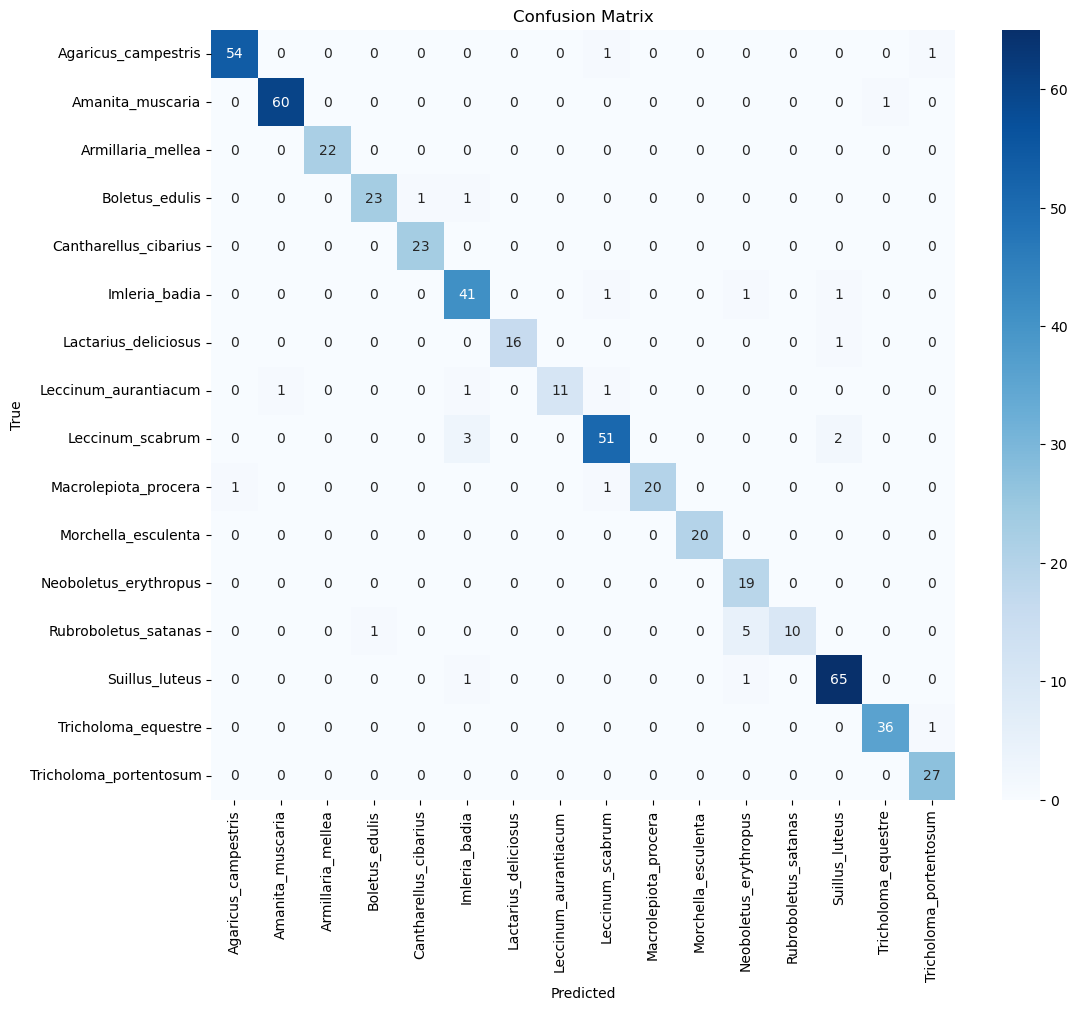

In [3]:
import os
import numpy as np
import onnxruntime as ort
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

# Set script directory and dataset paths
script_directory = os.getcwd()
directory_path_val = os.path.join(script_directory, "scripts", "downloaded_images", "val")

# Preprocessing transformations for validation data
val_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load validation dataset
val_dataset = datasets.ImageFolder(directory_path_val, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Class-to-index mapping
class_to_idx = val_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Mapowanie indeksów klas na nazwy folderów:")
for idx, class_name in idx_to_class.items():
    print(f"Indeks {idx}: Klasa '{class_name}'")

# Load the ONNX model with GPU execution provider
onnx_model_path = os.path.join(script_directory, "scripts", "model.onnx")
session = ort.InferenceSession(onnx_model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

print("Execution providers:", session.get_providers())

# Perform inference and collect predictions
all_labels = []
all_preds = []

print("Running inference on validation set...")
for images, labels in val_loader:
    # Prepare input tensor for ONNX model
    input_tensor = images.numpy().astype(np.float32)
    outputs = session.run([output_name], {input_name: input_tensor})
    preds = np.argmax(outputs[0], axis=1)

    all_labels.extend(labels.numpy())
    all_preds.extend(preds)

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Mapowanie indeksów klas na nazwy folderów:
Indeks 0: Klasa 'Pieczarka polna (Agaricus campestris)'
Indeks 1: Klasa 'Muchomor czerwony (Amanita muscaria)'
Indeks 2: Klasa 'Opieńka miodowa (Armillaria mellea)'
Indeks 3: Klasa 'Borowik szlachetny (Boletus edulis)'
Indeks 4: Klasa 'Kurka (Pieprznik jadalny, Cantharellus cibarius)'
Indeks 5: Klasa 'Podgrzybek brunatny (Imleria badia)'
Indeks 6: Klasa 'Rydz (Lactarius deliciosus)'
Indeks 7: Klasa 'Koźlarz czerwony (Leccinum aurantiacum)'
Indeks 8: Klasa 'Koźlarz babka (Leccinum scabrum)'
Indeks 9: Klasa 'Czubajka kania (Macrolepiota procera)'
Indeks 10: Klasa 'Smardz jadalny (Morchella esculenta)'
Indeks 11: Klasa 'Borowik ceglastopory (Neoboletus erythropus)'
Indeks 12: Klasa 'Borowik szatański (Rubroboletus satanas)'
Indeks 13: Klasa 'Maślak zwyczajny (Suillus luteus)'
Indeks 14: Klasa 'Gąska zielonka (Tricholoma equestre)'
Indeks 15: Klasa 'Gąska niekształtna (Tricholoma portentosum)'
Execution providers: ['CUDAExecutionProvider', 'CPUExe

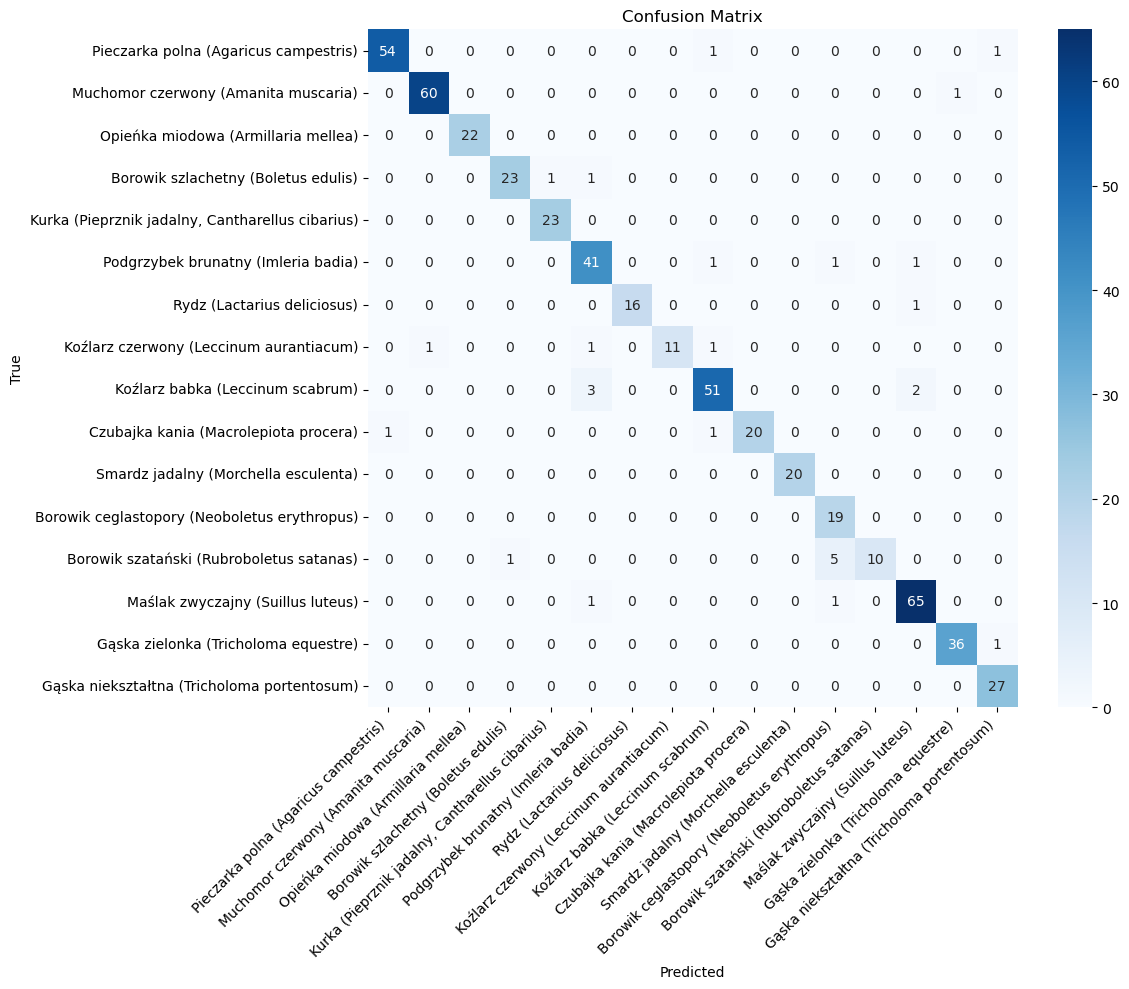

In [2]:
import os
import numpy as np
import onnxruntime as ort
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

# Set script directory and dataset paths
script_directory = os.getcwd()
directory_path_val = os.path.join(script_directory, "scripts", "downloaded_images", "val")

# Preprocessing transformations for validation data
val_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load validation dataset
val_dataset = datasets.ImageFolder(directory_path_val, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Class-to-index mapping with Polish names
class_to_idx = val_dataset.class_to_idx
idx_to_class = {
    0: "Pieczarka polna (Agaricus campestris)",
    1: "Muchomor czerwony (Amanita muscaria)",
    2: "Opieńka miodowa (Armillaria mellea)",
    3: "Borowik szlachetny (Boletus edulis)",
    4: "Kurka (Pieprznik jadalny, Cantharellus cibarius)",
    5: "Podgrzybek brunatny (Imleria badia)",
    6: "Rydz (Lactarius deliciosus)",
    7: "Koźlarz czerwony (Leccinum aurantiacum)",
    8: "Koźlarz babka (Leccinum scabrum)",
    9: "Czubajka kania (Macrolepiota procera)",
    10: "Smardz jadalny (Morchella esculenta)",
    11: "Borowik ceglastopory (Neoboletus erythropus)",
    12: "Borowik szatański (Rubroboletus satanas)",
    13: "Maślak zwyczajny (Suillus luteus)",
    14: "Gąska zielonka (Tricholoma equestre)",
    15: "Gąska niekształtna (Tricholoma portentosum)"
}

print("Mapowanie indeksów klas na nazwy folderów:")
for idx, class_name in idx_to_class.items():
    print(f"Indeks {idx}: Klasa '{class_name}'")

# Load the ONNX model with GPU execution provider
onnx_model_path = os.path.join(script_directory, "scripts", "model.onnx")
session = ort.InferenceSession(onnx_model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print("Execution providers:", session.get_providers())

# Perform inference and collect predictions
all_labels = []
all_preds = []

print("Running inference on validation set...")
for images, labels in val_loader:
    # Prepare input tensor for ONNX model
    input_tensor = images.numpy().astype(np.float32)
    outputs = session.run([output_name], {input_name: input_tensor})
    preds = np.argmax(outputs[0], axis=1)

    all_labels.extend(labels.numpy())
    all_preds.extend(preds)

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Polish class names for the confusion matrix
polish_class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=polish_class_names))

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=polish_class_names, yticklabels=polish_class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
